In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Transformer Conditional Neural Process 1D- Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Conditional Neural Process (no latents) for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [ ]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, SelfAttentionEncoder
from skssl.predefined import MLP, add_flat_input
from skssl.transformers.neuralproc.datasplit import context_target_split
from skssl.utils.helpers import rescale_range

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 32
num_points = 128
num_samples = 100000
n_epochs = 30


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(3, num_points-50))


def get_model(x_dim, y_dim):
    return AttentiveNeuralProcess(x_dim, y_dim,
                                  XEncoder=SinusoidalEncodings,
                                 attention="multihead",
                                  #encoded_path="deterministic",
                                 XYEncoder=SelfAttentionEncoder,
                                 Decoder=_DeepMLP,
                                 r_dim=r_dim,
                                 LatentEncoder=MLP,
                                 get_cntxt_trgt=get_cntxt_trgt)


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))


/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

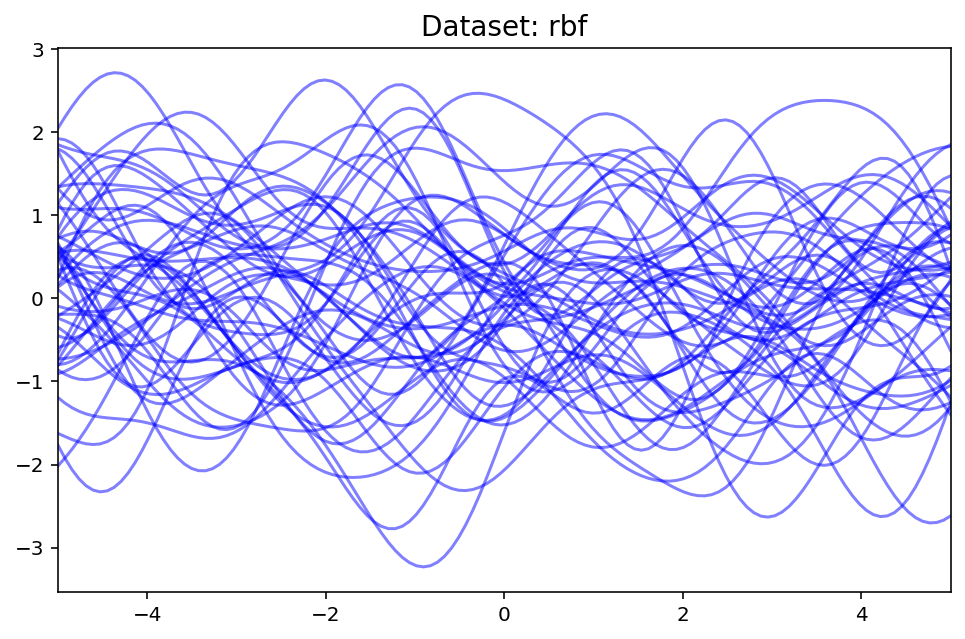

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

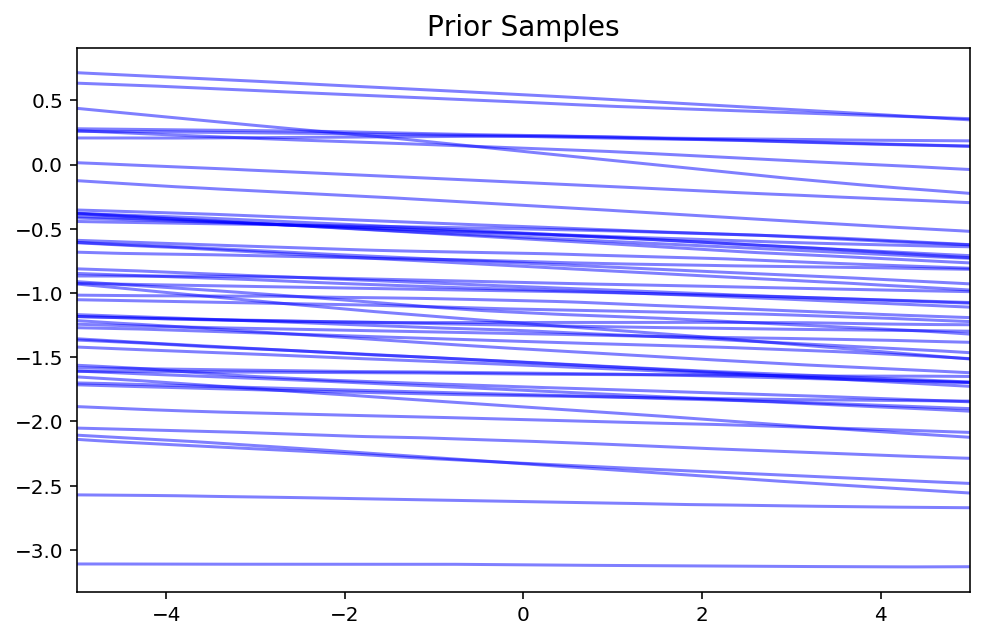

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                 train_split=None,
                                 lr=1e-4) # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      173.6947  54.2313


      2      145.5407  50.0346


      3      121.8417  54.5041


      4      101.5487  54.4749


      5       85.6884  54.6017


      6       75.4657  54.2997


      7       62.0534  54.3790


      8       53.3369  54.4495


      9       42.4188  50.1329


     10       36.5522  54.4832


     11       32.7567  54.6367


     12       29.5989  54.5368


     13       23.8470  37.8826


     14       19.2265  26.6957


     15       13.9361  26.6483


     16       11.5061  46.1102


     17        8.9160  54.5671


     18        6.5762  54.5170


     19        3.9398  54.4093


     20        2.3457  54.6712


     21        1.2167  54.4955


     22       -1.9014  54.6767


     23       -4.9336  54.5054


     24       -7.9264  51.2931


     25      -12.1114  54.6444


     26      -14.6166  54.6527


     27      -15.8829  54.6375


     28      -18.6321  54.0982


     29      -20.1360  51.4427


     30      -23.3814  54.5850


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

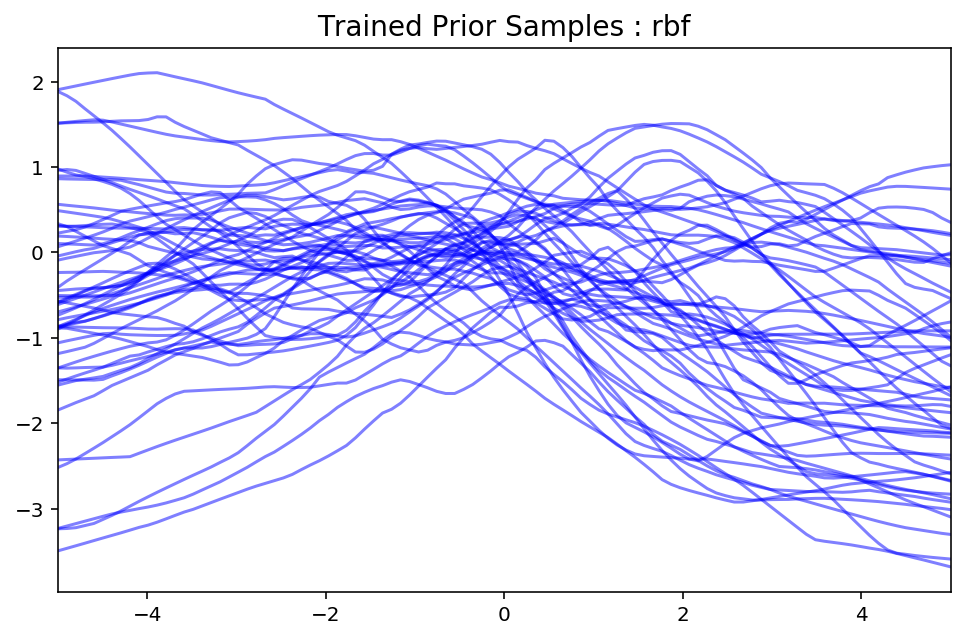

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k), min_max=dataset.min_max)

## Posterior

In [11]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

<Figure size 576x360 with 0 Axes>

Let's now use a single context point to see how much information is in the "learned implicit kernel"

In [12]:
for k,(neural_proc, dataset) in data_models.items():
    X = rescale_range(torch.tensor([[[-0.2]]]), dataset.min_max, (-1,1)) 
    Y = rescale_range(torch.tensor([[[-0.75]]]), dataset.min_max, (-1, 1))
    plot_posterior_samples(neural_proc, X, Y,  
                           is_plot_std=True, n_samples=30, min_max=dataset.min_max, 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

NameError: name 'rescale_range' is not defined

In [13]:
from skssl.utils.helpers import rescale_range 

for k,(neural_proc, dataset) in data_models.items():
    X = rescale_range(torch.tensor([[[-0.2]]]), dataset.min_max, (-1,1)) 
    Y = rescale_range(torch.tensor([[[0.75]]]), dataset.min_max, (-1, 1))
    plot_posterior_samples(neural_proc, X, Y,  
                           is_plot_std=True, n_samples=30, min_max=dataset.min_max, 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

<Figure size 576x360 with 0 Axes>